In [320]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import folium
import matplotlib.pyplot as plt
import numpy as np

In [321]:
#import police boundaries
police_divs= gpd.read_file('CMPD_Police_Divisions.geojson')
police_divs_offices = gpd.read_file('CMPD_Police_Division_Offices.geojson')
police_beats = gpd.read_file('CMPD_Police_Response_Areas.geojson')

#import shooting incident files
shooting_officer= gpd.read_file('CMPD_OfficerInvolved_Shootings__Officers.geojson')
shooting_individual= gpd.read_file('CMPD_OfficerInvolved_Shootings__Individuals.geojson')
shooting_incidents= gpd.read_file('CMPD_OfficerInvolved_Shootings__Incidents.geojson')
#print(shooting_incidents.head())
#print(shooting_individual.head())
#print(shooting_officer.head())


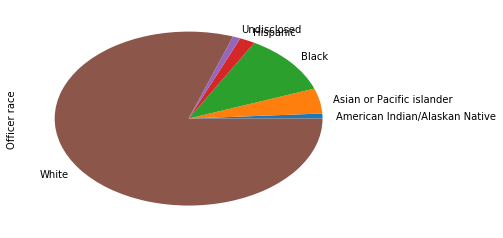

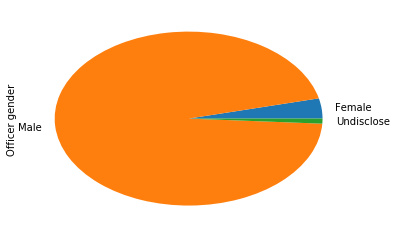

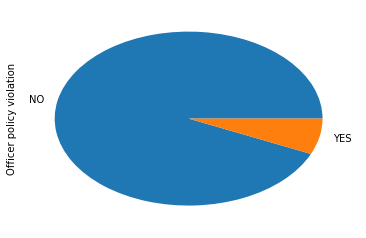

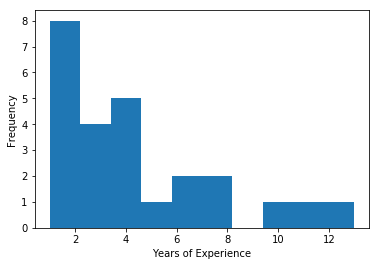

In [322]:
#shooting officer demographics
#create df of officer information
cols_of_interest = ['OFFICER_RACE', 'OFFICER_GENDER', 'OFFICER_POLICY_VIOLATION', 'OFFICER_EXPERIENCE_YEARS']

officerdf = shooting_officer[cols_of_interest]

for i in cols_of_interest[0:3]:
    officer_demo = officerdf.groupby(i)[i].count()
    officer_demo.plot(kind='pie', label= i.replace('_', ' ').capitalize())
    plt.show()

officerdf =  officerdf.groupby('OFFICER_EXPERIENCE_YEARS')['OFFICER_EXPERIENCE_YEARS'].count()
officerdf.plot(kind='hist')
plt.xlabel('Years of Experience')
plt.show()

Empty GeoDataFrame
Columns: [INCIDENT_ID, INDIVIDUAL_RACE, INDIVIDUAL_GENDER, INDIVIDUAL_AGE, INDIVIDUAL_INJURY_TYPE, ObjectID, YR, Latitude, Longitude, CreationDate, Creator, EditDate, Editor, geometry]
Index: []


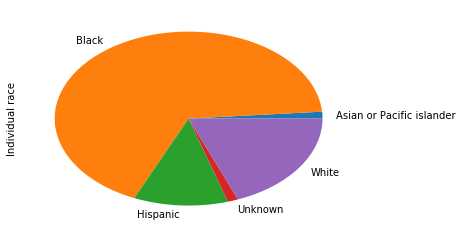

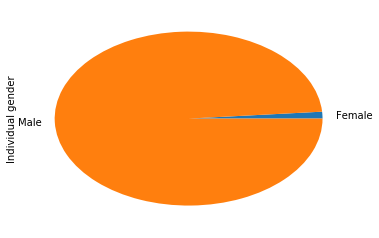

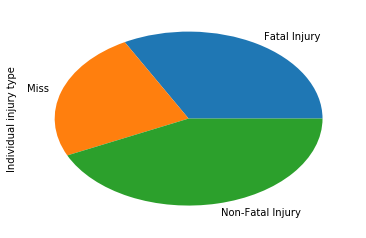

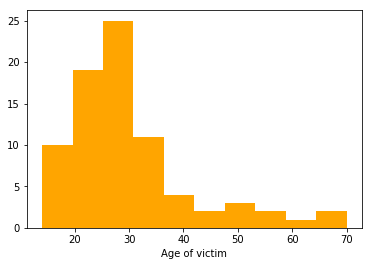

In [323]:
#shooting victim demographics
#remove NaN values bfore slicing to avoid SettingWithCopy Error
shooting_individual.loc[shooting_individual.INDIVIDUAL_AGE.isnull(), 'INDIVIDUAL_AGE'] = shooting_individual.INDIVIDUAL_AGE.mean()
print(shooting_individual[shooting_individual.INDIVIDUAL_AGE.isnull()])

victim_cols_of_interest = ['INDIVIDUAL_RACE', 'INDIVIDUAL_GENDER', 'INDIVIDUAL_INJURY_TYPE' , 'INDIVIDUAL_AGE']
victimdf = shooting_individual[victim_cols_of_interest]

for i in victim_cols_of_interest[0:3]:
    victim_demo = victimdf.groupby(i)[i].count()
    victim_demo.plot(kind='pie', label= i.replace('_', ' ').capitalize())
    plt.show()

plt.hist(victimdf['INDIVIDUAL_AGE'], range = (14.0, 70.0), color = 'orange')
plt.xlabel('Age of victim')
plt.show()

In [324]:
#Prepare shooting dfs for merging, analysis
for df in [shooting_officer, shooting_individual, shooting_incidents]:
    #drop empty geometry columns
    df.drop(columns=['geometry'], inplace=True)

    #create geometry column from lat/long data
    #df['geometry'] = df.apply(lambda x: Point((x.Longitude, x.Latitude)), axis=1)

    #drop extra data
    extra_cols = ['CreationDate', 'Creator', 'Editor', 'EditDate', 'ObjectID', 'YR']
    df.drop(columns= extra_cols, inplace=True)

    #prepare shooting incident files for merging
    df.set_index('INCIDENT_ID', inplace=True)
    df.sort_index(inplace=True)

#merge all dataframes, drop redundancies
shootings= shooting_incidents.merge(shooting_individual[['INDIVIDUAL_RACE','INDIVIDUAL_GENDER','INDIVIDUAL_AGE','INDIVIDUAL_INJURY_TYPE']], on='INCIDENT_ID').merge(shooting_officer[['OFFICER_RACE','OFFICER_GENDER','OFFICER_EXPERIENCE_YEARS','OFFICER_POLICY_VIOLATION']], on= 'INCIDENT_ID')
shootings['Date'] = shootings['YEAR_MONTH'].astype(str) + '-01'
shootings.drop(columns=['MN','YEAR_MONTH'], inplace=True)
shootings['Date'] = pd.to_datetime(shootings['Date'])
#print(shootings.head())

In [325]:
charlotte = folium.Map(location=[35.2271, -80.8431], zoom_start=11, tiles= "Stamen Toner")

In [326]:
#Police divisions
folium.GeoJson(police_divs, style_function= lambda features: {'fillColor': 'yellow','color':'#ff0a00', 'weight':'2.0', 'fill_opacity': '0.4'}, name='Police Divisions').add_to(charlotte)

#Police patrol areas
folium.GeoJson(police_beats, style_function= lambda features: {'fillColor': 'yellow', 'color':'#0a2496', 'fill_opacity': '0.1'}, name= 'Patrol areas').add_to(charlotte)

In [327]:
#Police division offices
folium.GeoJson(police_divs_offices, name= "Division Offices").add_to(charlotte)

In [328]:
for row in shootings.iterrows():
    row_values= row[1]
    shot = (row_values.Latitude, row_values.Longitude)

    try:
        if row_values.INDIVIDUAL_RACE == 'White':
            marker = folium.RegularPolygonMarker(location= shot, fill_color='#ede1d1', number_of_sides= 3, popup = folium.Popup('<strong>'+row_values.INDIVIDUAL_INJURY_TYPE+'</strong>'))
        elif row_values.INDIVIDUAL_RACE == 'Black':
            marker = folium.RegularPolygonMarker(location= shot, fill_color= '#15120e', number_of_sides= 5, popup = folium.Popup('<strong>'+row_values.INDIVIDUAL_INJURY_TYPE+'</strong>'))
        elif row_values.INDIVIDUAL_RACE == 'Hispanic':
            marker = folium.RegularPolygonMarker(location= shot, fill_color='#a89070', number_of_sides= 6, popup = folium.Popup('<strong>'+row_values.INDIVIDUAL_INJURY_TYPE+'</strong>'))
        else:
            marker = folium.RegularPolygonMarker(location= shot, fill_color='red', popup = folium.Popup('<strong>'+row_values.INDIVIDUAL_INJURY_TYPE+'</strong>'))
        marker.add_to(charlotte)
    except Exception:
        continue

In [329]:
folium.LayerControl().add_to(charlotte)

In [330]:
charlotte